In [1]:
from sqlalchemy import create_engine, text
from pathlib import Path
import os
import pandas as pd
from tab_benchmark.datasets import datasets_characteristics_path
from itertools import product
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
import matplotlib.pyplot as plt

# Save Results

## Load mlflow runs

In [2]:
db_port = 5001
db_name = 'tab_benchmark'
w = 'clust9'
url = f'postgresql://{w}.ceremade.dauphine.lan:{db_port}/{db_name}'
engine = create_engine(url)
query = 'SELECT experiments.name from experiments'
experiment_names = pd.read_sql(query, engine)['name'].tolist()
results_dir = Path('~/tab_benchmark/results')
os.makedirs(results_dir, exist_ok=True)

In [3]:
experiment_names

['Default',
 'dnn_classification',
 'dnn_regression',
 'gbdt_classification',
 'gbdt_regression',
 'dnn_classification_others',
 'xgb_hpo_classification',
 'dnn_classification_transformer_max_1h']

In [4]:
experiment_names = [
    'dnn_classification', 'gbdt_classification', 'dnn_classification_others'
]

In [5]:
params_columns = [
    'model_nickname',
    'model_name',
    'seed_model',
    'dataset_name',
    'task_id',
    'task_name',
    'task_fold',
    'EXCEPTION',
    'SLURMD_NODENAME',
    'was_evaluated'
]

In [6]:
latest_metrics_columns = [
    'final_test_logloss',
    'final_test_auc',
    'final_test_auc_0',
    'final_test_auc_1',
]

In [7]:
params_columns_query = [f"'{p}'" for p in params_columns]
params_columns_query = ', '.join(params_columns_query)

In [8]:
experiment_names_query = [f"'{e}'" for e in experiment_names]
experiment_names_query = ', '.join(experiment_names_query)

In [9]:
query = f"""
SELECT
	runs.run_uuid,
    runs.status,
    runs.start_time,
    runs.end_time,
	params."key",
	params.value
FROM
	runs
LEFT JOIN params ON
	params.run_uuid = runs.run_uuid
LEFT JOIN experiments ON
	experiments.experiment_id = runs.experiment_id
WHERE
	params."key" IN ({params_columns_query})
	AND experiments.name IN ({experiment_names_query})
"""
df_params = pd.read_sql(query, engine)
df_params = df_params.pivot(columns='key', index=['run_uuid', 'status', 'start_time', 'end_time'], values='value').reset_index()
df_params = df_params.set_index('run_uuid')

In [10]:
latest_metrics_columns_query = [f"'{m}'" for m in latest_metrics_columns]
latest_metrics_columns_query = ', '.join(latest_metrics_columns_query)

In [11]:
query = f"""
SELECT
	runs.run_uuid,
	latest_metrics."key",
	latest_metrics.value
FROM
	runs
LEFT JOIN latest_metrics ON
	latest_metrics.run_uuid = runs.run_uuid
LEFT JOIN experiments ON
	experiments.experiment_id = runs.experiment_id
WHERE
	latest_metrics."key" IN ({latest_metrics_columns_query})
	AND experiments.name IN ({experiment_names_query})
"""
df_latest_metrics = pd.read_sql(query, engine)
df_latest_metrics = df_latest_metrics.pivot(columns='key', index='run_uuid', values='value')

In [12]:
df_runs_raw = df_params.join(df_latest_metrics)
# df_runs_raw = df_runs_raw.rename(columns={'model_nickname': 'model_name', 'random_seed': 'seed_model'})
df_runs_raw['duration'] = (df_runs_raw['end_time'] - df_runs_raw['start_time'])/(3600*1000)

In [14]:
df_runs_raw

key,status,start_time,end_time,EXCEPTION,SLURMD_NODENAME,dataset_name,model_name,model_nickname,seed_model,task_fold,task_id,task_name,was_evaluated,final_test_auc,final_test_auc_0,final_test_auc_1,final_test_logloss,duration
run_uuid,,,,,,,,,,,,,,,,,,
00041295adf6408b98d494e867298b73,FINISHED,1726250759876,1.726251e+12,NaN,clust10,house_16H,XGBClassifier,TabBenchmarkXGBClassifier,0,7,3686,binary_classification,True,NaN,0.047283,0.952717,0.250468,0.001176
00083774fba44fb18ad8ad1ffd1b872b,FINISHED,1726261646899,1.726262e+12,NaN,clust11,sonar,MLP,TabBenchmarkMLP,0,6,39,binary_classification,True,NaN,0.181818,0.818182,0.580241,0.042290
000a8cfefda64cf6a167df2a708afb51,FINISHED,1726579322368,1.726585e+12,NaN,clust3,pendigits,Transformer,TabBenchmarkTransformer,0,3,32,classification,True,0.998939,NaN,NaN,0.047548,1.668499
000fe9adec414671b4351d0a59068b5a,FINISHED,1726498691179,1.726502e+12,NaN,clust8,MiniBooNE,ResNet,TabBenchmarkResNet,0,3,168335,binary_classification,True,NaN,0.016003,0.983997,0.144317,0.898571
000fed3e509e4798860d517d73053b89,FINISHED,1726390097040,1.726394e+12,NaN,clust11,JapaneseVowels,MLP,TabBenchmarkMLP,0,8,3510,classification,True,0.999885,NaN,NaN,0.033935,0.962025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fff398eb93e44723965b7ad6d3c402b4,FINISHED,1726480473007,1.726480e+12,NaN,clust9,haberman,XGBClassifier,TabBenchmarkXGBClassifier,0,3,42,binary_classification,True,NaN,0.478261,0.521739,0.571754,0.000175
fffd37c94d70462d95975f12e6349dfa,FINISHED,1726886027263,1.726886e+12,NaN,clust12,wdbc,TabNet,TabBenchmarkTabNet,0,2,9946,binary_classification,True,NaN,0.035714,0.964286,0.246439,0.003828
fffd70ef80eb428099e2310c82d05054,FINISHED,1726574894958,1.726575e+12,NaN,clust12,visualizing_environmental,CatBoostClassifier,TabBenchmarkCatBoostClassifier,0,3,3602,binary_classification,True,NaN,0.200000,0.800000,0.460515,0.000299


## Load specs file with all datasets being used

In [15]:
datasets_characteristics = pd.read_csv(datasets_characteristics_path)
datasets_classification = datasets_characteristics.loc[datasets_characteristics.task_name.isin(('classification', 'binary_classification'))]
datasets_classification_tasks_ids = datasets_classification['task_id'].tolist()
datasets_classification_names = datasets_classification['dataset_name'].tolist()
all_classification = pd.DataFrame({'dataset_names': datasets_classification_names}, index=datasets_classification_tasks_ids)

## Delete duplicate runs (if any) and complete some models that cannot run with some datasets

In [16]:
non_duplicate_columns = [
    'model_name',
    'seed_model',
    'task_id',
    'task_fold',    
]

In [17]:
df_runs = df_runs_raw.dropna(axis=0, how='all', subset=['final_test_logloss']).copy()
df_runs = df_runs.loc[(~df_runs.duplicated(non_duplicate_columns))]

In [18]:
# # some combinations of model-dataset will never run (memory needed is too high > 2 TiB)
# model_to_input = ['SkRandomForestModel', 'SkExtraTreeModel', 'SkGradientBoostingModel', 'SkExtraTreesModel', 'SkDecisionTreeModel', 'SkRidgeClassifierCVModel']
# dataset_name_to_input = ['albert']
# folds_to_input = [str(i) for i in range(5)]
# seed_dataset_to_input = ['0']
# seed_model_to_input = ['0']
# for model_name in model_to_input:
#     for dataset_name in dataset_name_to_input:
#         for fold in folds_to_input:
#             for seed_dataset in seed_dataset_to_input:
#                 for seed_model in seed_model_to_input:
#                     data_to_cat = {
#                         'model_name': model_name,
#                         'dataset_name': dataset_name,
#                         'fold': fold,
#                         'seed_model': seed_model,
#                         'seed_dataset': seed_dataset,
#                         'test_auc': 0,
#                         'test_logloss': 1e5,
#                         'duration': 1e5*3600
#                     }
#                     df_to_cat = pd.DataFrame(data_to_cat, index=[0])
#                     df_runs = pd.concat([df_runs, df_to_cat], axis=0)

In [19]:
df_runs.to_csv(results_dir / 'runs_classification.csv')

# Missing

In [20]:
def get_missing_runs(df, columns_names, should_contain_values):
    df = df.copy()
    indexes = product(*should_contain_values)
    df_should_contain = pd.DataFrame(index=indexes)
    contain = [df[column_name] for column_name in columns_names]
    df['indexes'] = list(zip(*contain))
    df_missing = df.join(df_should_contain, 'indexes', how='right')
    df_missing = df_missing.loc[df_missing[columns_names[0]].isna()]
    return df_missing

In [21]:
df_runs['model_name'].unique().tolist()

['XGBClassifier',
 'MLP',
 'Transformer',
 'ResNet',
 'LGBMClassifier',
 'CatBoostClassifier',
 'TabNet',
 'TabTransformer']

In [22]:
non_duplicate_columns = [
    'model_name',
    'seed_model',
    'task_id',
    # 'dataset_name',
    'task_fold',    
]

In [23]:
seed_model = ['0']
model_name = [
    'XGBClassifier',
    'CatBoostClassifier',
    'LGBMClassifier',
    'MLP',
    'ResNet',
    'Transformer',
    'TabNet'
    # 'TabTransformer'
]
fold = [str(i) for i in range(10)]
columns_names = non_duplicate_columns
# dataset_names = datasets_classification_names.copy()
dataset_tasks = [str(task) for task in datasets_classification_tasks_ids]
# datasets_removed = ['aloi', 'dionis', 'poker', 'covertype', 'higgs_uci', 'kddcup99_sf']
# for dataset in datasets_removed:
#     dataset_names.remove(dataset)
should_contain_values = [model_name, seed_model, dataset_tasks, fold]
df_missing = get_missing_runs(df_runs, columns_names, should_contain_values)

In [28]:
print(*(pd.DataFrame(df_missing.indexes.to_list())[2].unique()))

167124 167121 146825 3952 189355 168329 2076 9974 3573 168868 9910 167125 3945 3946 3948 189356 10092 168908 9981 168909 167140 168910 3891 168337 14970 3481 168911 9976 146824 3950 190410 168338 168332 3485 9964 3889 168331 9890


In [29]:
with pd.option_context('display.max_rows', None, 'display.max_colwidth', None):
    display(df_missing['indexes'])

NaN    (CatBoostClassifier, 0, 167124, 9)
NaN    (CatBoostClassifier, 0, 167121, 0)
NaN    (CatBoostClassifier, 0, 167121, 1)
NaN    (CatBoostClassifier, 0, 167121, 3)
NaN    (CatBoostClassifier, 0, 167121, 4)
NaN    (CatBoostClassifier, 0, 167121, 5)
NaN    (CatBoostClassifier, 0, 167121, 6)
NaN    (CatBoostClassifier, 0, 167121, 7)
NaN    (CatBoostClassifier, 0, 167121, 8)
NaN    (CatBoostClassifier, 0, 167121, 9)
NaN    (CatBoostClassifier, 0, 146825, 1)
NaN    (CatBoostClassifier, 0, 146825, 2)
NaN    (CatBoostClassifier, 0, 146825, 3)
NaN    (CatBoostClassifier, 0, 146825, 4)
NaN    (CatBoostClassifier, 0, 146825, 5)
NaN    (CatBoostClassifier, 0, 146825, 7)
NaN    (CatBoostClassifier, 0, 146825, 8)
NaN    (CatBoostClassifier, 0, 146825, 9)
NaN      (CatBoostClassifier, 0, 3952, 0)
NaN      (CatBoostClassifier, 0, 3952, 2)
NaN      (CatBoostClassifier, 0, 3952, 4)
NaN      (CatBoostClassifier, 0, 3952, 5)
NaN      (CatBoostClassifier, 0, 3952, 6)
NaN      (CatBoostClassifier, 0, 3

## Calculate means and stds for each task and for each model

In [19]:
def get_dfs_means_stds_both(df, column_model_name, column_task_id, column_metric, all_datasets):
    df = df.copy()
    columns = [column_model_name, column_task_id, column_metric]
    means = (
        df[columns].
        groupby(columns[:-1]).
        mean().
        reset_index(level=column_model_name).
        pivot(columns=column_model_name).
        droplevel(level=0,axis=1)
    )
    stds = (
        df[columns].
        groupby(columns[:-1]).
        std().
        reset_index(level=column_model_name).
        pivot(columns=column_model_name).
        droplevel(level=0,axis=1)
    )
    dfs = [means, stds]
    new_dfs = []
    for df in dfs:
        new_dfs.append(all_datasets.join(df, how='left'))
    both = pd.concat([new_dfs[0], new_dfs[1]], keys=['mean', 'std'], axis=1)
    both.columns = both.columns.swaplevel(0, 1)
    both = both.sort_index(axis=1)
    return new_dfs[0], new_dfs[1], both

In [20]:
column_model_name = 'model_name'
column_task_id = 'task_id'
column_metric = 'final_test_logloss'
logloss = get_dfs_means_stds_both(df_runs, 
                               column_model_name, 
                               column_task_id,
                               column_metric, 
                               all_classification)
column_metric = 'final_test_auc'
auc = get_dfs_means_stds_both(df_runs, 
                                   column_model_name, 
                                   column_task_id,
                                   column_metric,
                                   all_classification)
column_metric = 'duration'
duration = get_dfs_means_stds_both(df_runs, 
                                   column_model_name, 
                                   column_task_id,
                                   column_metric,
                                   all_classification)

In [21]:
metrics = ['logloss', 'auc', 'duration']
dfs = [logloss, auc, duration]
for metric_name, df in zip(metrics, dfs):
    df[0].to_csv(results_dir/(metric_name + '_means.csv'))
    df[1].to_csv(results_dir/(metric_name + '_stds.csv'))

# Display Results

## General

In [60]:
idx = pd.IndexSlice
df = logloss[2].copy()
df = df[model_name]
df = df.loc[dataset_names]
# df = df.drop('allstate_claim_predictions')
slice_ = idx[idx[:], idx[:,'mean']]
df.style.highlight_min(subset=slice_, axis=1)

In [62]:
idx = pd.IndexSlice
df = auc[2].copy()
df = df[model_name]
df = df.loc[dataset_names]
# df = df.drop('allstate_claim_predictions')
slice_ = idx[idx[:], idx[:,'mean']]
df.style.highlight_max(subset=slice_, axis=1)

In [64]:
def friedman_nemenyi_test(df, model_column, block_column, metric_column, ascending_rank=False, alpha=0.95):
    df = df.copy()
    groups = [df.loc[df[model_column] == model, metric_column] for model in pd.unique(df[model_column])]
    res_friedman = friedmanchisquare(*groups)
    if res_friedman.pvalue < 1 - alpha:
        res_nemenyi = sp.posthoc_nemenyi_friedman(df, y_col=metric_column, block_col=block_column, 
                                                  group_col=model_column, melted=True)
        ranks = df.groupby([block_column])[metric_column].rank(ascending=ascending_rank)
        df['rank'] = ranks
        mean_rank = df.groupby(model_column)['rank'].mean()
        return res_friedman, res_nemenyi, mean_rank
    else:
        print(f'pvalue of {res_friedman.pvalue} is greater than alpha of {alpha}')
        return res_friedman, None, None

In [65]:
figures_folder = results_dir / 'figures'
os.makedirs(figures_folder, exist_ok=True)

/home/users/belucci/miniconda3/envs/tabular_benchmark/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


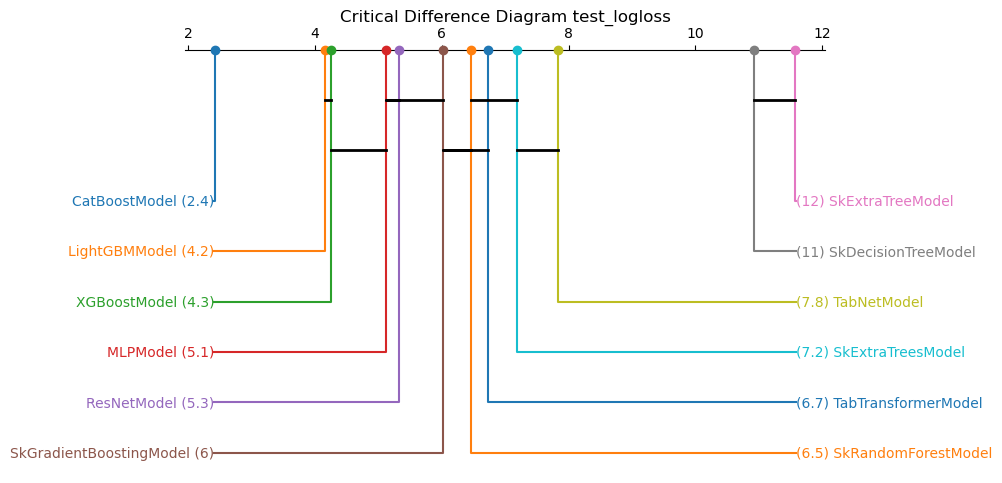

In [72]:
df = df_runs.copy()
df = df.loc[df['model_name'].isin(model_name)]
df = df.loc[df['dataset_name'].isin(dataset_names)]
df['dataset_name_fold_seed_model_seed_dataset'] = df['dataset_name'] + df['fold'] + df['seed_model'] + df['seed_dataset']
metric = 'test_logloss'
ascending_rank = True
model_column = 'model_name'
block_column = 'dataset_name_fold_seed_model_seed_dataset'
alpha = 0.95
res_friedman, res_nemenyi, mean_rank = friedman_nemenyi_test(df, model_column, block_column, 
                                                             metric, ascending_rank, alpha)
if res_nemenyi is not None and mean_rank is not None:
    plt.subplots(figsize=(10, 5))
    plt.title(f'Critical Difference Diagram {metric}')
    sp.critical_difference_diagram(mean_rank, res_nemenyi)
    plt.tight_layout()
    plt.savefig(figures_folder / f'cdd_{metric}')

/home/users/belucci/miniconda3/envs/tabular_benchmark/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


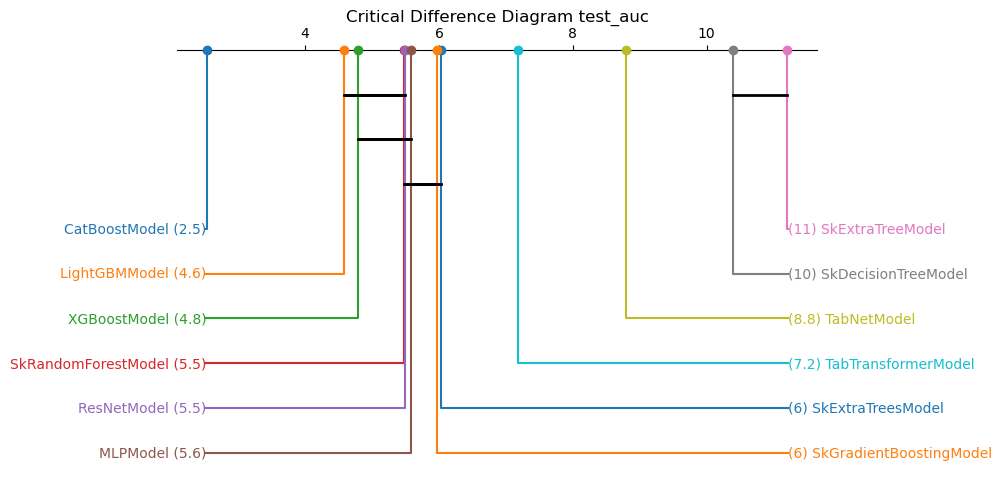

In [84]:
df = df_runs.copy()
# df['test_auc'] = df['test_auc'].replace(0, 1e-5)
df = df.loc[df['model_name'].isin(model_name)]
df = df.loc[(df['dataset_name'].isin(dataset_names)) & (df['dataset_name'] != 'arrhythmia')]
df['dataset_name_fold_seed_model_seed_dataset'] = df['dataset_name'] + df['fold'] + df['seed_model'] + df['seed_dataset']
metric = 'test_auc'
ascending_rank = False
model_column = 'model_name'
block_column = 'dataset_name_fold_seed_model_seed_dataset'
alpha = 0.95
res_friedman, res_nemenyi, mean_rank = friedman_nemenyi_test(df, model_column, block_column, 
                                                             metric, ascending_rank, alpha)
if res_nemenyi is not None and mean_rank is not None:
    plt.subplots(figsize=(10, 5))
    plt.title(f'Critical Difference Diagram {metric}')
    sp.critical_difference_diagram(mean_rank, res_nemenyi)
    plt.tight_layout()
    plt.savefig(figures_folder / f'cdd_{metric}')

# Debug and explore

In [45]:
df_runs_raw[columns_names].duplicated().any()

False

In [36]:
df_to_delete = df_runs_raw.loc[df_runs_raw.test_logloss.isna()]

In [37]:
df_to_delete

key,status,start_time,end_time,dataset_name,model_name,model_nickname,seed_model,task_fold,task_id,task_name,test_auc,test_logloss,duration
run_uuid,,,,,,,,,,,,,
03cab7b441e34b40bd8ad8dc60fcd836,FINISHED,1726540996777,1726578901049,insurance_company,Transformer,TabBenchmarkTransformer,0,7,362081,binary_classification,NaN,NaN,10.528964
049febc2449c46c3afdd56d2afcaff5c,FINISHED,1726551253408,1726578901052,GesturePhaseSegmentationProcessed,Transformer,TabBenchmarkTransformer,0,4,14969,classification,NaN,NaN,7.679901
04abe372bcd84f2eadaea736307038f8,FINISHED,1726579962480,1726586658278,credit,Transformer,TabBenchmarkTransformer,0,6,361055,binary_classification,NaN,NaN,1.859944
05539e85c0604675b3f93096e8bc1feb,FINISHED,1726270121868,1726270157619,kc1,Transformer,TabBenchmarkTransformer,0,7,3917,binary_classification,NaN,NaN,0.009931
0e5ef3a920bf49869074fe5950bff043,FINISHED,1726579689874,1726586658276,artificial-characters,Transformer,TabBenchmarkTransformer,0,4,14964,classification,NaN,NaN,1.935667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
f1f2c35f12104ead8b8f7e6e320c92d4,FINISHED,1726458758738,1726458823282,magic,Transformer,TabBenchmarkTransformer,0,4,146206,binary_classification,NaN,NaN,0.017929
f26f36657d21499280e65e2581921373,FINISHED,1726573970041,1726578901053,pendigits,Transformer,TabBenchmarkTransformer,0,2,32,classification,NaN,NaN,1.369726
f2def598dec344d5a4e82e1a5510e4bc,FINISHED,1726583892918,1726586658286,Pulsar-Dataset-HTRU2,Transformer,TabBenchmarkTransformer,0,5,362099,binary_classification,NaN,NaN,0.768158


In [38]:
run_uuid_query = [f"'{run_id}'" for run_id in df_to_delete.index]
run_uuid_query = ', '.join(run_uuid_query)

In [39]:
query = f"""
UPDATE runs
SET lifecycle_stage = 'deleted'
WHERE run_uuid IN ({run_uuid_query}) 
"""
with engine.begin() as conn:
    conn.execute(text(query))

for i, row in df_runs_raw.iterrows():
    run_id = row.run_id
    model_name = row['params.model_name']
    with mlflow.start_run(run_id) as run:
        mlflow.log_param('model_nickname', model_name)    